## Import packages and set environment variables

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import src as ddfa_node
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load and prepare data

In [8]:
data_path = "/home/michael/Synology/Desktop/Data/Julia/data/human_data.npy"
features = 6
data = ddfa_node.load_data_normalize(features, data_path)

In [2]:
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")

In [6]:
from scipy.signal import savgol_filter
from src import takens_embedding
window_length = 50
polyorder = 3
data = np.load("/home/michael/Synology/Desktop/Data/Julia/data/VDP_SDEs.npy")[:, 3000:, :][:, :, :]
data = (data - data.mean(axis=1)[:, None, :]) / data.std(axis=1)[:, None, :]
for trial in range(data.shape[0]):
    data[trial, :, :] = savgol_filter(data[trial], window_length=window_length, polyorder=polyorder, axis=0)

τ, k = 1, 5
time_delayed_data = takens_embedding(data[:, ::5, :], τ, k)

### Taken's Embed the data with optimal parameters

In [9]:
time_delayed_data, k, τ = ddfa_node.embed_data(data, maxlags=np.inf)

19


/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/src/tde.py:132: RuntimeWarning: divide by zero encountered in divide
  a.append(np.divide(np.linalg.norm(tsrecon[ind_m, :]-tsrecon[ind, :], ord=np.inf, axis=1),
/home/michael/Synology/Desktop/Data/Python/Gait-Signatures/NeuralODE/DDFA_NODE/src/tde.py:132: RuntimeWarning: invalid value encountered in divide
  a.append(np.divide(np.linalg.norm(tsrecon[ind_m, :]-tsrecon[ind, :], ord=np.inf, axis=1),


Data has been embedded using a delay of 19 timesteps and an embedding dimension of 5


### Prepare data for training

In [ ]:
sequence_length = 300
skip = 1
dt = 0.01
noise_std = 0.1
n_noisy_copies = 4
train_size = 1.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

data_train, _, samp_ts, _ = ddfa_node.prepare_train_val_data(time_delayed_data,
                                                            sequence_length=sequence_length,
                                                            skip=skip,
                                                            train_size=train_size, 
                                                            noise_std=noise_std, 
                                                            n_noisy_copies=n_noisy_copies,
                                                            dt=dt, device=device)
sequence_length = 1500
_, data_val, _, val_ts = ddfa_node.prepare_train_val_data(time_delayed_data,
                                                            sequence_length=sequence_length,
                                                            skip=skip,
                                                            train_size=1-train_size, 
                                                            noise_std=noise_std, 
                                                            n_noisy_copies=n_noisy_copies,
                                                            dt=dt, device=device)
# keep_samples = 3000
# keep_val_samples = 1000
# data_train, data_val = data_train[:keep_samples], data_val[:keep_val_samples]
print(data_train.shape, data_val.shape)

## Train models

### Set hyperparameters for training

In [5]:
batch_size = 128
latent_dim = 16
n_hidden = 64
dec_hidden = 32
obs_dim = data_train.shape[-1]
rnn_hidden = 256
n_itrs = 2000
lr = 1e-3
dropout = 0.25
alpha = 4e-6
checkpoint_itr = 10

### Train model from scratch

In [ ]:
model, losses = ddfa_node.train_network(data_train, data_val, samp_ts, val_ts, n_itrs, 
                                                 latent_dim=latent_dim, 
                                                 n_hidden=n_hidden,
                                                 obs_dim=obs_dim,
                                                 rnn_hidden=rnn_hidden, 
                                                 dec_hidden=dec_hidden, 
                                                 batch_size=batch_size, 
                                                 lr=lr, dropout=dropout, 
                                                 noise_std=noise_std,
                                                 alpha=alpha, device=device,
                                                 checkpoint_itr=checkpoint_itr,
                                                 adjoint=False)

Iter: 0, total loss: 24.789609909057617, kl loss: 2.8695385, mse loss: 2.020315170288086
mean loss: 0.002435659058392048, std loss: 1.7144840955734253
val loss: 10.827262878417969, val kl loss: 7.132009, val mse loss: 2.0087456703186035
val mean loss: 0.0012957602739334106, val std loss: 1.6852123737335205


Iter: 10, total loss: 23.45618438720703, kl loss: 2.77575425, mse loss: 1.954770565032959
mean loss: 0.0023852637968957424, std loss: 1.1303375959396362
val loss: 10.925864219665527, val kl loss: 7.8819645, val mse loss: 2.2168993949890137
val mean loss: 0.025955647230148315, val std loss: 0.8010452389717102


Iter: 20, total loss: 20.90660858154297, kl loss: 2.4989985, mse loss: 1.7623934745788574
mean loss: 0.0010128191206604242, std loss: 0.7826619148254395
val loss: 10.125744819641113, val kl loss: 7.2506515, val mse loss: 2.04146146774292
val mean loss: 0.0019511762075126171, val std loss: 0.8316816091537476


Iter: 30, total loss: 19.735605239868164, kl loss: 2.36893025, mse 

### Further train an existing model

In [ ]:
func, rec, dec = model # extract model components
model, losses = ddfa_node.train_network(data_train, data_val, samp_ts, val_ts, n_itrs,
                                                 func=func, rec=rec, dec=dec, # add models here
                                                 latent_dim=latent_dim, 
                                                 n_hidden=n_hidden,
                                                 obs_dim=obs_dim, 
                                                 rnn_hidden=rnn_hidden, 
                                                 dec_hidden=dec_hidden, 
                                                 batch_size=batch_size, 
                                                 lr=lr, dropout=dropout, 
                                                 noise_std=noise_std,
                                                 alpha=alpha, device=device,
                                                 checkpoint_itr=checkpoint_itr)

## Evaluate model

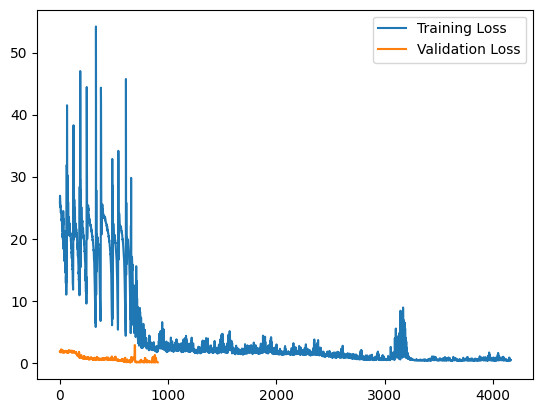

In [116]:
plt.plot(losses[0], label="Training Loss")
plt.plot(losses[2], label="Validation Loss")
plt.legend()
plt.show()

## Get self-driven data

In [227]:
seeding_steps = sequence_length
generated_steps = 3500
self_generated_data, self_generated_latents = ddfa_node.generate_data_from_model(model, time_delayed_data[:, :seeding_steps, :], steps=generated_steps, dt=dt)

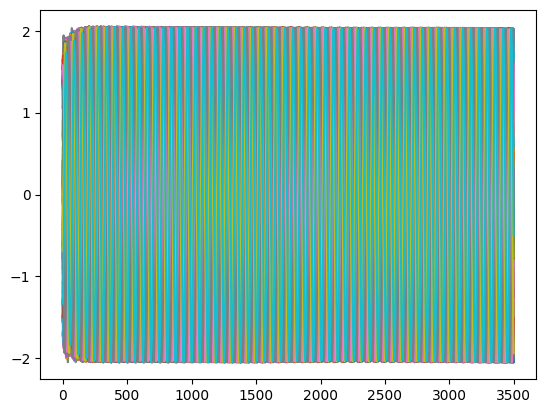

In [228]:
%matplotlib inline
trial = 35
plt.plot(self_generated_data[:, :, 0].T)
plt.show()

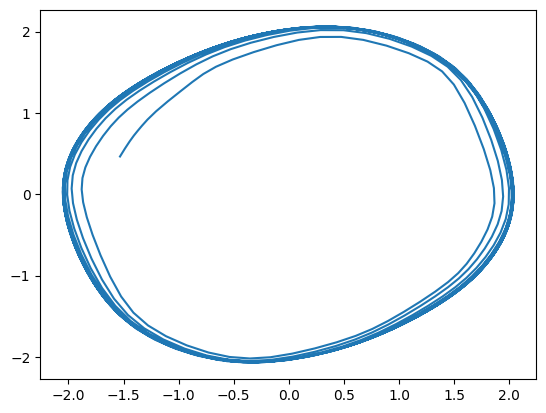

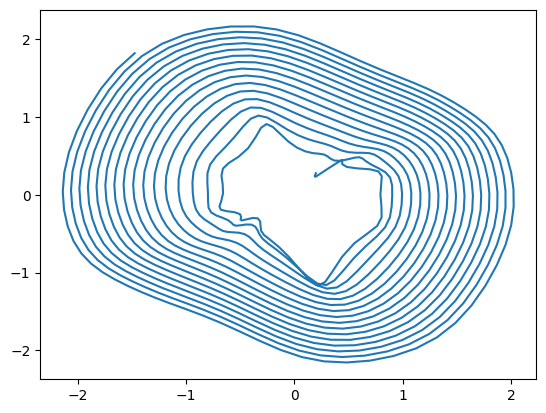

In [231]:
trial = 9
plt.plot(self_generated_data[trial, :1000, 0], self_generated_data[trial, :1000, k+1::k+1])
plt.show()
trial = 99
plt.plot(self_generated_data[trial, :1000, 0] - self_generated_data[9, :1000, 0], self_generated_data[trial, :1000, k+1::k+1] - self_generated_data[9, :1000, k+1::k+1])

In [221]:
np.save("data/VDP_gen_data.npy", self_generated_data)
ddfa_node.save_model(model, "models/vdp_good")

In [226]:
model = ddfa_node.load_model("models/vdp_good")
for block in model:
    block.to(device)

## Validate extrapolations from model

In [ ]:
ddfa_node.validate_self_gen_data(model, self_generated_data, data, k=k)

## Estimate Floquet multipliers

In [ ]:
λs = ddfa_node.get_FM(self_generated_data)

## Visualize Floquet multipliers

In [ ]:
ddfa_node.make_FM_plots(λs)